In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
# Model / data parameters
num_classes = 100
input_shape = (32, 32, 1)
(x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# convert class vectors to binary class matrices
y_train100 = keras.utils.to_categorical(y_train100, num_classes)
y_test100 = keras.utils.to_categorical(y_test100, num_classes)


In [4]:
def dataset():
    num_outputs = 10
    validation_size = 5000
    batch_size = 32
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    train_labels = tf.keras.utils.to_categorical(train_labels,num_outputs)
    test_labels = tf.keras.utils.to_categorical(test_labels,num_outputs)
    
    validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
    train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    
    def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        # image = tf.reshape(image, (28,28,1))
        image = tf.image.rgb_to_grayscale(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label



    train_ds_size = len(list(train_ds))
    test_ds_size = len(list(test_ds))
    validation_ds_size = len(list(validation_ds))

    print("trainSize {}".format(train_ds_size))
    print("testSize {}".format(test_ds_size))

    train_ds = (train_ds
                    .map(augment_images)
                    .shuffle(buffer_size=train_ds_size,seed=42,reshuffle_each_iteration=False)
                    .batch(batch_size=batch_size, drop_remainder=True))

    test_ds = (test_ds
                    .map(augment_images)
                    #   .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    validation_ds = (validation_ds
                    .map(augment_images)
                    #   .shuffle(buffer_size=validation_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    return (train_ds, test_ds, validation_ds)

train_ds, test_ds, validation_ds = dataset()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorSliceDataset: Dst tensor is not initialized. [Op:TensorSliceDataset]

In [ ]:
def rotateImg(model,digit_one, evidence_func = tf.nn.relu, verbose = False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    # digit_one = x_train[6]
    import matplotlib.pyplot as plt
    
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    UB = []
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(32,32))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,32,32)))
        mean = tf.reduce_mean(_pred).numpy()
        # evidence = tf.nn.softplus(_pred + abs(mean))
        evidence = evidence_func(_pred)
        alpha = evidence + 1
        # print(_pred, evidence, "label", np.argmax(_pred))
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        M = alpha / S
        # E = alpha - 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    
        # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        UBmax_ratio = np.amax(M)/1 - u
        UB.append(UBmax_ratio.numpy().mean())

        # alpha = evidence + 1
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        if verbose:
            print("pred", _pred)
            print("evidence", evidence)
            print("belief", prob)
            print("label", np.argmax(_pred), "uncertainity", u.numpy() )
            print("UB", UBmax_ratio)
            
        # alpha = exp_evidence(logits)
        # print("uncert",u)
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True)        
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (32*len(rimgs), 32))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [ ]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function

In [6]:
batch_size = 128
epochs = 15
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def loss_EDL(func=tf.compat.v1.digamma):
    def loss_func(p, logits): 
        # logits = tf.nn.softmax(logits)
        alpha = exp_evidence(logits)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
        alp = E*(1-p) + 1 
        # B =  annealing_coef * KL(alp)
        return (A)
    return loss_func


class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32)
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)



def CE(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels, m)
        annealing_rate =  lambda_callback.lambda_t
        C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        return A + C
        # return (A + B) + C
    return  cross_entropy_evidence


#inspired by https://github.com/selflein/MA-EBM/blob/1e90da47118127ab432d11b9e2b2aa57305386fc/uncertainty_est/models/ebm/mcmc_priornet.py
def MAEBM():
    def loss(labels, outputs):
        evidence = tf.nn.exp(outputs) #activation function
        alpha = evidence + 1
        alpha_0 = tf.reduce_sum(alpha)
        
        UCE_loss = (labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))).mean()
        
        # UCE_loss  += entropy_reg_weight  * -Dirichlet(alpha).entropy().mean()
        return 
    return loss 

loss = MAEBM()
x = np.array([.1,.1,.5])
y = np.array([0.0,0.0,1])
print(MAEBM(y,x))

TypeError: MAEBM() takes 0 positional arguments but 2 were given

In [ ]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(32,32,1)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(10),
#     ]
# )
# model.save("./models/mini_cifar_blank.hdf5")

In [296]:
model_entropy = tf.keras.models.load_model("./models/mini_cifar_blank.hdf5")

crossent = evidence_crossentropy()
# model_old.compile(loss=CCE_fromlogits(), optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=["accuracy"])
model_entropy.compile(loss=CCE_fromlogits(), optimizer="adam", metrics=["accuracy"])
model_entropy.fit(train_ds,epochs = 10)


Epoch 1/10
1406/1406 [==============================] - 6s 3ms/step - loss: 2.4892 - accuracy: 0.1890
Epoch 2/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.9382 - accuracy: 0.2967
Epoch 3/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.7152 - accuracy: 0.3939
Epoch 4/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.5550 - accuracy: 0.4616
Epoch 5/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.4620 - accuracy: 0.4972
Epoch 6/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.4008 - accuracy: 0.5174
Epoch 7/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.3502 - accuracy: 0.5355
Epoch 8/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.3276 - accuracy: 0.5453
Epoch 9/10
1406/1406 [==============================] - 5s 3ms/step - loss: 1.3071 - accuracy: 0.5530
Epoch 10/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.292

<function __main__.evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, num_outputs=10)>

In [317]:
import math
def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
    return -sumEntropies
def getPredictions_old(model):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(test_ds):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        # print("pred", predictions)
        # print(y)
        # if num_outputs > 1:
        
        # print("output ", k, outputs)
        for j, prediction in enumerate(predictions):
            evidence =tf.nn.softmax(prediction)
            alpha = evidence +1
            # alpha = exp_evidence(logits)
            S = sum(alpha)
            E = alpha - 1

            Mass = alpha / S
            # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)

            u = num_classes / S
            
            # Uncert.append(u.numpy().mean())
            ### for just CE, use the softmax value
            ### for evidential CE, use the softplus sum 
            Uncert.append(((calcEntropy_Tensors2(evidence)).numpy()))
            # for pred
            Results.append(np.argmax(prediction))
            # Pred.append((tf.argmax((prediction))
            # Pred[k].append((np.amax(tf.nn.softplus(prediction))))
            # Pred[k].append(np.amax(tf.nn.softmax(prediction)))
            Labels.append(np.argmax(y[j]))
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df
outputs = getPredictions_old(model_old)
print(outputs)
Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
print("Correct", Correct, "incorrect", Incorrect)
print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



      x  y    uncert correct
0     3  3  2.501721       1
1     8  8  1.364177       1
2     3  8  2.926862       0
3     8  0  1.050845       0
4     6  6  2.266597       1
...  .. ..       ...     ...
9979  3  3  2.291421       1
9980  0  0  0.172730       1
9981  4  4  1.789247       1
9982  7  2  2.586388       0
9983  1  0  1.574507       0

[9984 rows x 4 columns]
Correct 1.5580854 incorrect 2.1961775
overallAcc 0.5959535256410257


      x  y    uncert correct
0     3  3  0.995939       1
4     6  6  0.930759       1
5     6  6  0.673691       1
6     1  1  0.952024       1
8     3  3  0.888149       1
...  .. ..       ...     ...
9971  9  9  0.259289       1
9973  0  0  0.955900       1
9975  7  7  0.000454       1
9978  7  7  0.974543       1
9980  0  0  0.996335       1

[5999 rows x 4 columns]


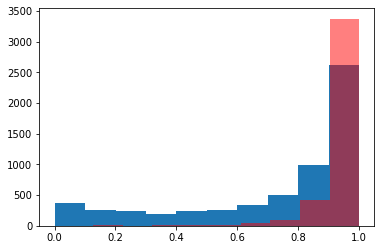

In [313]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
# print(outputs['uncert'].tolist())
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [314]:
Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
print("Correct", Correct, "incorrect", Incorrect)

Correct 0.7313676 incorrect 0.9426204


In [318]:
Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
print("Correct", Correct, "incorrect", Incorrect)

T = outputs.loc[(outputs['correct'] == True)]
F = outputs.loc[(outputs['correct'] == False)]
print (T.loc[T['uncert'] < Incorrect])
print (F.loc[F['uncert'] < Incorrect])
print("thresholded accuracy is: ", len(T.loc[T['uncert'] <= Incorrect])/len(outputs.loc[outputs['uncert'] <= Incorrect]), "compared to overallAcc of ", len(outputs.loc[(outputs['correct'] == True)])/len(outputs), ", accepted = ", len(outputs.loc[outputs['uncert'] <= Incorrect])/ len(outputs))

# New method: 22.6 error rate using mean of F and dirichlet uncert.
# cross entropy + entropyUncert, thresholded accuracy is: # cross entropy + entropyUncert, thresholded accuracy is:  0.7242982893207108 compared to overallAcc of  0.5959535256410257, accepted = .60
# normal cross entropy, thresholded accuracy is:  0.2893677003624648 compared to overallAcc of  0.4072516025641026
# evidenceCE + KL(1) models thresholded accuracy is:  0.3894404332129964 compared to overallAcc of 0.37
# new method: DCE + annealing KL, thresholded accuracy is:  0.7737104825291181 compared to overallAcc of  0.6008613782051282 , accepted =  0.5417668269230769


Correct 1.5580854 incorrect 2.1961775
      x  y    uncert correct
1     8  8  1.364177       1
11    9  9  0.284582       1
13    7  7  0.865887       1
14    9  9  0.539464       1
15    8  8  1.525376       1
...  .. ..       ...     ...
9975  7  7  0.039945       1
9976  5  5  1.242551       1
9977  5  5  1.754696       1
9980  0  0  0.172730       1
9981  4  4  1.789247       1

[4361 rows x 4 columns]
      x  y    uncert correct
3     8  0  1.050845       0
24    4  5  2.049549       0
36    7  4  1.631764       0
44    8  0  1.715337       0
46    5  3  2.059015       0
...  .. ..       ...     ...
9957  9  0  1.889917       0
9960  0  2  0.575867       0
9966  3  6  2.100452       0
9968  5  3  1.795432       0
9983  1  0  1.574507       0

[1660 rows x 4 columns]
thresholded accuracy is:  0.7242982893207108 compared to overallAcc of  0.5959535256410257 , accepted =  0.6030649038461539


In [288]:
model_old.evaluate(test_ds)


312/312 [==============================] - 1s 2ms/step - loss: 1.7167 - accuracy: 0.4073


[1.716747522354126, 0.40725159645080566]

label 7


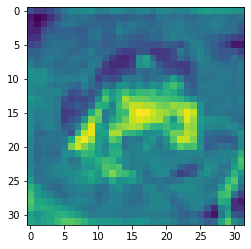

[[-96.29549  -74.438    -35.96151  -35.24919  -60.230453 -42.16723
  -28.217884 -60.40748  -37.902344 -63.792206]]
label 6 : 6 uncert 0.98416775 beliefMax 0.10427252


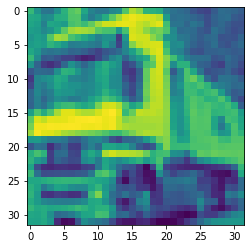

[[-112.94196   -83.55418   -79.48123  -110.01307   -96.09681   -93.760994
  -114.069595  -48.075943  -96.377884   32.574768]]
label 9 : 9 uncert 0.2778318 beliefMax 0.74969834


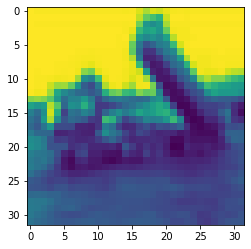

[[ -47.785397  -48.005993  -31.482508  -64.156006 -125.401146  -64.63181
   -48.345203  -33.80836   -84.45921   -11.272548]]
label 9 : 9 uncert 0.9588732 beliefMax 0.12694727


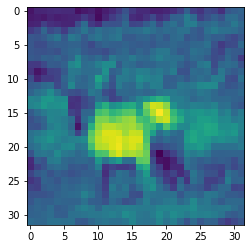

[[-41.805603 -68.53921  -39.541454 -49.38393  -10.721301 -39.98491
   -9.133043 -18.451176 -85.486534 -22.830168]]
label 6 : 4 uncert 0.90377665 beliefMax 0.12663685


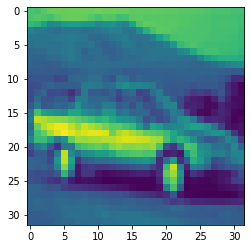

[[ -69.44524    52.063328 -126.90888   -97.91265  -109.48716  -113.461395
   -52.215153  -84.609344 -141.80153    -8.321941]]
label 1 : 1 uncert 0.051849537 beliefMax 0.95104414


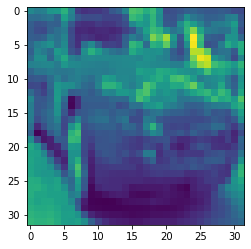

[[-111.6044     12.080178  -97.916725  -57.917492  -60.626778  -68.74874
   -23.355286  -23.889912  -89.38082   -53.49603 ]]
label 1 : 1 uncert 0.73818594 beliefMax 0.32087794


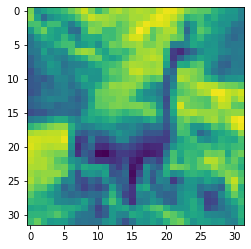

[[ -43.627853  -88.57044   -34.910088  -61.76265   -16.688675  -69.61904
   -85.58345    -9.115326 -101.3379    -33.22536 ]]
label 7 : 2 uncert 0.93693966 beliefMax 0.1313503


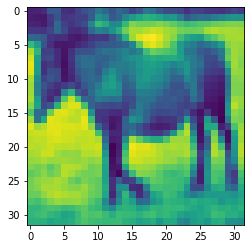

[[-131.54515  -115.73558   -95.31001   -70.814224  -75.45158   -36.784946
  -115.15171    67.51646  -173.47466  -134.38428 ]]
label 7 : 7 uncert 0.011554118 beliefMax 0.9895702


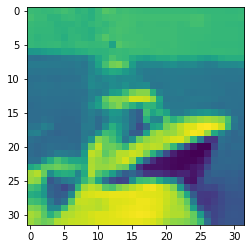

[[ -61.231987  -63.211693  -41.497334  -71.08326  -123.922455 -130.01277
  -126.222275 -118.83558    -6.875857  -73.92087 ]]
label 8 : 8 uncert 0.9501944 beliefMax 0.14279413


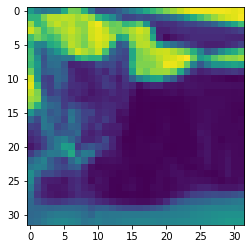

[[ -59.742764   -47.55654    -67.161194   -35.0733     -53.76768
   -77.080055  -123.49747    -32.18164    -68.18743     -4.3825116]]
label 9 : 3 uncert 0.9316419 beliefMax 0.15327035


In [219]:
test_img = x_train[7]
label = y_train[7]
print("label", np.argmax(label))
# plt.imshow(test_img)
# plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
# rotateImg(model,test_img, exp_evidence)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134
num_classes = 10 
for i in range(10):    
    kmnist_digit = x_train[i]
    kmnist_digit = tf.image.rgb_to_grayscale(kmnist_digit, name=None)
    kmnist_label = y_train[i]
    plt.imshow(kmnist_digit)
    plt.show()
    _pred=model.predict(tf.reshape(kmnist_digit,(1,32,32)))
    evidence =exp_evidence(_pred)
    alpha = evidence +1
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    
    Mass = alpha / S
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print(_pred)
    print("label", np.argmax(_pred),":",np.argmax(kmnist_label), "uncert", u.numpy().mean(), "beliefMax", np.amax(Mass).mean() )

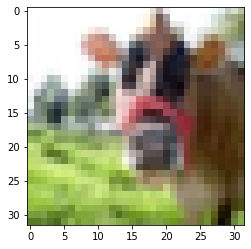

[[14.643928   0.9683198 24.877962  26.661484  18.353466  27.253912
  -1.1403317 22.763943  -2.744812  11.975938 ]]
tf.Tensor(
[[0.06819709 0.0269165  0.16693789 0.19703133 0.09307358 0.20827502
  0.02423408 0.13756807 0.02254018 0.05522626]], shape=(1, 10), dtype=float32)
label: 5 actual: 19 uncert 0.12807165 beliefMax 0.20827502


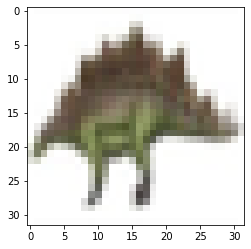

[[ 35.639824   22.637215   29.428516   -3.670013   -6.9926343  -3.2467244
  -47.67065    51.452625  -36.00113    33.844105 ]]
tf.Tensor(
[[0.13107964 0.03834094 0.07210438 0.00611216 0.00540498 0.00622031
  0.00364137 0.62325966 0.00370931 0.11012726]], shape=(1, 10), dtype=float32)
label: 7 actual: 29 uncert 0.036106598 beliefMax 0.62325966


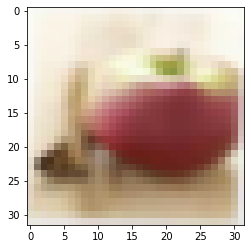

[[ 23.709072  17.035952  19.166891  18.609238  14.852516  13.751228
  -34.88141    6.567625  41.74606   27.729286]]
tf.Tensor(
[[0.08951806 0.04965362 0.05963036 0.0568108  0.04141389 0.03789258
  0.00788013 0.022393   0.5047759  0.13003166]], shape=(1, 10), dtype=float32)
label: 8 actual: 0 uncert 0.076464735 beliefMax 0.5047759


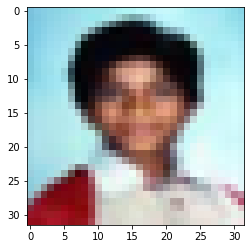

[[  0.30399016 -27.37308     49.287632    57.33607    -27.64167
   73.591934    10.7486515    8.349744   -32.187233    -6.693833  ]]
tf.Tensor(
[[9.9806406e-04 5.2326609e-04 6.8413682e-02 1.5238917e-01 5.2242290e-04
  7.7234393e-01 1.9311914e-03 1.6241140e-03 5.1110855e-04 7.4308075e-04]], shape=(1, 10), dtype=float32)
label: 5 actual: 11 uncert 0.004914476 beliefMax 0.77234393


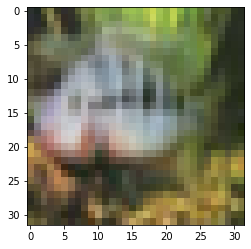

[[ 1.3409456 17.653044  21.503557  36.936974  30.310747  38.63542
  17.79691   27.2123    36.007225  38.232872 ]]
tf.Tensor(
[[0.00902043 0.02879867 0.04034854 0.17335208 0.09140148 0.2046641
  0.029155   0.06816979 0.15833487 0.19675504]], shape=(1, 10), dtype=float32)
label: 5 actual: 1 uncert 0.042082705 beliefMax 0.2046641


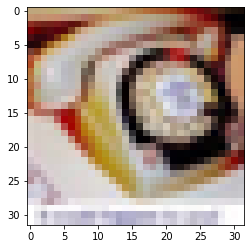

[[13.134911  29.576143  30.209156  42.70013    5.502317  47.71514
  -7.8669596 15.029394   4.8493614 31.151659 ]]
tf.Tensor(
[[0.01722647 0.07392673 0.07851913 0.26473227 0.00997878 0.43474832
  0.00531252 0.02005821 0.00957876 0.08591877]], shape=(1, 10), dtype=float32)
label: 5 actual: 86 uncert 0.03650344 beliefMax 0.43474832


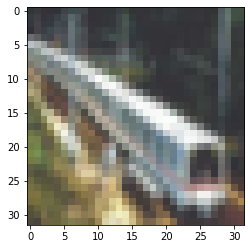

[[ 42.08082   27.593573  35.56395   19.605     17.007023  -6.023871
   35.564808 -15.631642  53.7165   -27.375439]]
tf.Tensor(
[[0.17417695 0.04286217 0.0919975  0.02068573 0.01653707 0.0039506
  0.09200519 0.00308765 0.551979   0.00271813]], shape=(1, 10), dtype=float32)
label: 8 actual: 90 uncert 0.025528865 beliefMax 0.551979


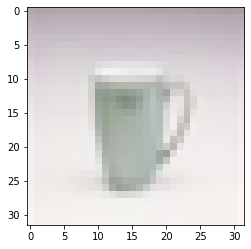

[[ 35.257126 -58.480297  57.6791    46.99408   32.245255  36.22746
   13.667192   7.897711  50.98685  -22.957697]]
tf.Tensor(
[[0.04951962 0.00141982 0.45426545 0.15697992 0.03700969 0.05442127
  0.00696891 0.00453445 0.23332253 0.00155828]], shape=(1, 10), dtype=float32)
label: 2 actual: 28 uncert 0.014157372 beliefMax 0.45426545


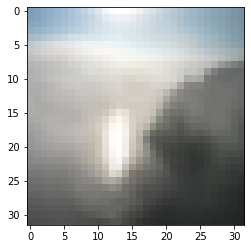

[[ 34.817963  -42.33062    40.249954   29.14123    28.037123   29.79841
   -4.540242   -8.816912   33.023647  -15.9124365]]
tf.Tensor(
[[0.18460606 0.00558756 0.31382653 0.10702831 0.09641597 0.11392415
  0.00900539 0.00778828 0.1551883  0.00662941]], shape=(1, 10), dtype=float32)
label: 2 actual: 23 uncert 0.055076566 beliefMax 0.31382653


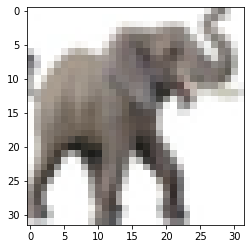

[[ 21.839018  -12.953072   61.606773   46.009686   37.943474   53.487587
  -22.860153   44.61104   -29.63644    -1.8842003]]
tf.Tensor(
[[0.01056955 0.00136259 0.50783694 0.10759075 0.04861683 0.22607704
  0.00117845 0.09368721 0.00112492 0.00195569]], shape=(1, 10), dtype=float32)
label: 2 actual: 31 uncert 0.010696958 beliefMax 0.50783694


In [149]:
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
# rotateImg(model,test_img, exp_evidence)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134
num_classes = 10 
for i in range(10):    
    kmnist_digit = x_train100[i]
    plt.imshow(kmnist_digit)
    plt.show()
    kmnist_digit = tf.image.rgb_to_grayscale(kmnist_digit, name=None)
    kmnist_label = y_train100[i]
  
    _pred=model.predict(tf.reshape(kmnist_digit,(1,32,32)))
    evidence =exp_evidence(_pred)
    alpha = evidence +1
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    
    Mass = alpha / S
    
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print(_pred)
    print(Mass)
    print("label:", np.argmax(_pred),"actual:",np.argmax(kmnist_label), "uncert", u.numpy().mean(), "beliefMax", np.amax(Mass) )

label 7


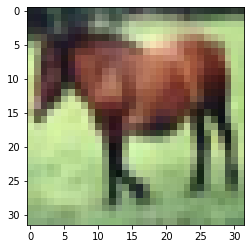

belief tf.Tensor(
[[0.00322426 0.00322426 0.00322426 0.00322426 0.00322426 0.00322426
  0.00322426 0.97098166 0.00322426 0.00322426]], shape=(1, 10), dtype=float32)
label 7 uncertainity [[0.03224262]]
belief tf.Tensor(
[[0.00562485 0.00562485 0.00562485 0.00562485 0.00562485 0.18627697
  0.00562485 0.7687242  0.00562485 0.00562485]], shape=(1, 10), dtype=float32)
label 7 uncertainity [[0.05624849]]
belief tf.Tensor(
[[0.04669936 0.04669936 0.04669936 0.04669936 0.04669936 0.04669936
  0.04669936 0.57970583 0.04669936 0.04669936]], shape=(1, 10), dtype=float32)
label 7 uncertainity [[0.46699357]]
belief tf.Tensor(
[[0.01295087 0.01295087 0.01295087 0.01295087 0.01295087 0.88344216
  0.01295087 0.01295087 0.01295087 0.01295087]], shape=(1, 10), dtype=float32)
label 5 uncertainity [[0.12950872]]
belief tf.Tensor(
[[0.00562689 0.00562689 0.00562689 0.00562689 0.00562689 0.90065056
  0.05433433 0.00562689 0.00562689 0.00562689]], shape=(1, 10), dtype=float32)
label 5 uncertainity [[0.056268

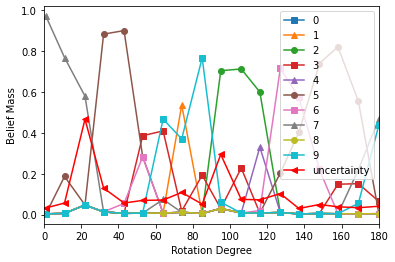

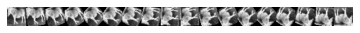

[0.03224262,
 0.056248486,
 0.46699357,
 0.12950872,
 0.056268852,
 0.0691819,
 0.07096912,
 0.108239256,
 0.050638005,
 0.29415005,
 0.07422776,
 0.07196195,
 0.102564536,
 0.029589528,
 0.049060024,
 0.037917644,
 0.033354897,
 0.040472403]

In [52]:
test_img = x_train[7]
label = y_train[7]
print("label", np.argmax(label))
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
rotateImg(model,test_img)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134

In [41]:

#entropy version



def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        # tf.print(tf.reduce_sum(A+B), tf.reduce_sum(C))
        
        return (A + B) + C
    return custom_loss_function

def lossMetric(annealing_coef):
    def lossMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(A+B)) # Note the `axis=-1`
    return lossMetric

def klMetric(annealing_coef):
    def klMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        # tf.print(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(C)) # Note the `axis=-1`
    return klMetric

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss_CE(annealing):
    def loss_func(p, logits): 
        
        func=tf.compat.v1.digamma
        X = tf.reduce_max(logits)
        # _logits = logits 
        # _logits[tf.argmax(_logits)] = tf.maximum(X,0) + abs(X) 
        E = tf.nn.softplus(logits)
        # tf.print("E", E,summarize=-1)
        alpha = E + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        # E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        CE = tf.minimum(1.0, tf.cast(1-annealing, tf.float32)) * crossentropy(p, logits)
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
        
        alp = E*(1-p) + 1 
        
        # B =  annealing * KL(alp,10)
    
        return (A + CE)#+B)
    return loss_func


model = tf.keras.models.load_model("./models/mini_cifar_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    annealing = tf.minimum(1,tf.cast((i)/10,tf.float32))
    # annealing = 0
    print("annealing_coef:", annealing)
    model.compile(loss=loss_CE(annealing), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=crossentropy, optimizer="adam", metrics=["accuracy",lossMetric(0),klMetric(0)])
    model.fit(train_ds,epochs = 1)
    
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 4.8709 - accuracy: 0.2148
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 3.7927 - accuracy: 0.3503
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 3.3257 - accuracy: 0.4322
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 3.0211 - accuracy: 0.4723
annealing_coef: tf.Tensor(0.4, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 2.7850 - accuracy: 0.4936
annealing_coef: tf.Tensor(0.5, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 2.5772 - accuracy: 0.5094
annealing_coef: tf.Tensor(0.6, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - los

In [48]:
from scipy.special import gammaln, polygamma, psi

def pdf(alphas):
    """Returns a Dirichlet PDF function
    Parameters
    ----------
    alphas : (K,) shape array
        The parameters for the distribution of shape ``(K,)``.
    Returns
    -------
    function
        The PDF function, takes an ``(N, K)`` shape input and gives an
        ``(N,)`` output.
    """
    alphap = alphas - 1
    c = np.exp(gammaln(alphas.sum()) - gammaln(alphas).sum())
    print(c)

    def dirichlet(xs):
        """Dirichlet PDF
        Parameters
        ----------
        xs : (N, K) shape array
            The ``(N, K)`` shape input matrix
        
        Returns
        -------
        (N,) shape array
            Point value for PDF
        """
        return c * (xs ** alphap).prod(axis=1)

    return dirichlet

pdf(np.array([1,1,1,]))


2.0


<function __main__.pdf.<locals>.dirichlet(xs)>

when using edl + annealing KL, after 10 epochs the accuracy has reduced to 0.1084. As the KL was added to the loss, the accuracy reverted to guessing. 

My guess is that the KL can't be added until the model has basically convereged to nearly its maximum accuracy.

label 7


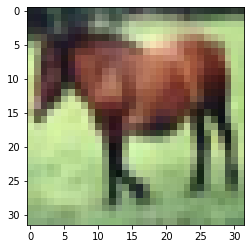

belief tf.Tensor(
[[0.00305102 0.00305102 0.00305102 0.00305102 0.20834844 0.15304928
  0.13198464 0.48831156 0.00305102 0.00305102]], shape=(1, 10), dtype=float32)
label 7 uncertainity [[0.03051018]]
belief tf.Tensor(
[[0.00671674 0.00671674 0.03600739 0.00699834 0.02269867 0.00671674
  0.21332581 0.68738604 0.00671674 0.00671674]], shape=(1, 10), dtype=float32)
label 7 uncertainity [[0.06716736]]
belief tf.Tensor(
[[0.00289692 0.00289692 0.15898588 0.11713394 0.19150378 0.0590177
  0.3690177  0.09275333 0.00289692 0.00289692]], shape=(1, 10), dtype=float32)
label 6 uncertainity [[0.02896918]]
belief tf.Tensor(
[[0.00423865 0.00423865 0.07203725 0.08273418 0.00423865 0.32765755
  0.41620705 0.0801708  0.00423865 0.00423865]], shape=(1, 10), dtype=float32)
label 6 uncertainity [[0.04238648]]
belief tf.Tensor(
[[0.00550268 0.00550268 0.00550268 0.10022508 0.00550268 0.28577963
  0.5754765  0.00550268 0.00550268 0.00550268]], shape=(1, 10), dtype=float32)
label 6 uncertainity [[0.0550267

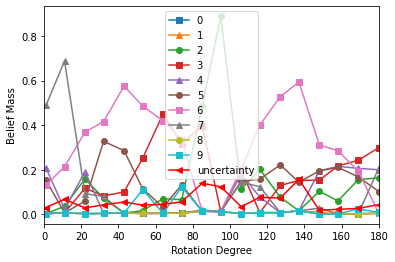

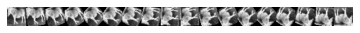

[0.030510176,
 0.067167364,
 0.028969184,
 0.042386476,
 0.055026755,
 0.04171494,
 0.04437357,
 0.05621271,
 0.13951626,
 0.12360987,
 0.033974998,
 0.07649132,
 0.07256533,
 0.15741009,
 0.018308982,
 0.022375165,
 0.026395448,
 0.043693334]

In [35]:
test_img = x_train[7]
label = y_train[7]
print("label", np.argmax(label))
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
rotateImg(model2,test_img)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134

label 4


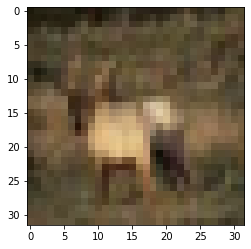

[[ -87.6867   -139.56873   -55.234898  -80.41443   -16.70354   -84.62599
   -33.317154  -77.62207  -116.43983   -76.09306 ]] [[0.0000000e+00 0.0000000e+00 1.0275164e-24 1.1924971e-35 5.5685796e-08
  1.7676600e-37 3.3926878e-15 1.9460913e-34 0.0000000e+00 8.9784736e-34]] label 4
[[ -88.557686 -125.52218   -63.68022   -54.38147   -25.039604  -84.6023
   -22.999487 -115.67389   -90.48114   -90.66408 ]] [[0.0000000e+00 0.0000000e+00 2.2081632e-28 2.4122804e-24 1.3348673e-11
  1.8100346e-37 1.0267146e-10 0.0000000e+00 0.0000000e+00 0.0000000e+00]] label 6
[[-118.72442  -107.035385  -81.13049   -56.255745  -40.086742  -85.30819
   -19.490595 -121.42352   -91.44083   -80.68401 ]] [[0.0000000e+00 0.0000000e+00 5.8273959e-36 3.7020342e-25 3.8953726e-18
  8.9356072e-38 3.4303798e-09 0.0000000e+00 0.0000000e+00 9.1070600e-36]] label 6
[[-136.0216     -81.333496   -86.247375   -40.09555    -61.33788
   -89.359184   -12.3938265 -117.74201   -113.643456  -109.20386  ]] [[0.0000000e+00 4.7567623e-36 

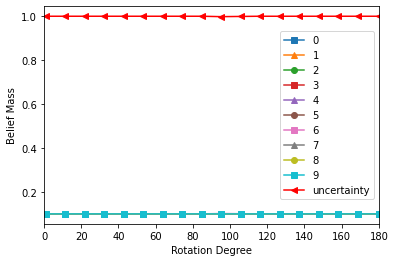

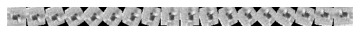

[1.0,
 1.0,
 1.0,
 0.99999964,
 0.99999267,
 0.9999998,
 0.9999949,
 1.0,
 1.0,
 0.998178,
 0.9991274,
 0.9999979,
 0.9999161,
 0.9999998,
 1.0,
 1.0,
 1.0,
 1.0]

In [35]:
test_img = x_train[3]
label = y_train[3]
print("label", np.argmax(label))
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
rotateImg(model,test_img)

label 9


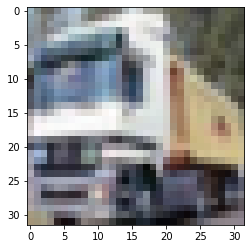

[[-767.4929  -558.80554 -689.0613  -634.43536 -537.4768  -253.5983
  -715.36707 -287.79837 -540.0717    75.1836 ]] [[ 0.      0.      0.      0.      0.      0.      0.      0.      0.
  75.1836]] label 9
[[-943.31104 -555.72736 -554.7268  -614.6346  -394.61047 -367.3838
  -348.7486  -240.52971 -515.62585   36.82446]] [[ 0.       0.       0.       0.       0.       0.       0.       0.
   0.      36.82446]] label 9
[[-1020.069      -551.51355    -599.8991     -743.33673    -313.34473
   -412.8282     -156.8344     -392.1961     -650.6461       -4.7052917]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.00900659]] label 9
[[-1011.0119   -495.81616  -776.67487  -708.2344   -563.535    -320.29623
     50.8776   -374.66522 -1071.3044   -187.2611 ]] [[ 0.      0.      0.      0.      0.      0.     50.8776  0.      0.
   0.    ]] label 6
[[-1044.3156   -558.31415  -912.491    -604.9306   -566.6595   -207.74927
     60.39919  -501.29456 -1105

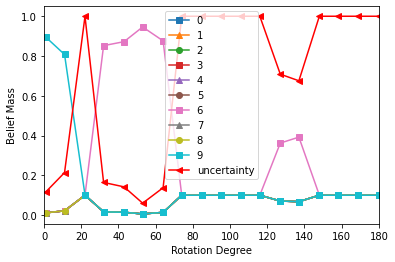

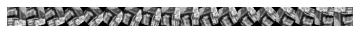

[0.117393486,
 0.2135636,
 0.99910015,
 0.16426402,
 0.14204709,
 0.059994407,
 0.13770476,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7086523,
 0.67547303,
 1.0,
 1.0,
 1.0,
 1.0]

In [60]:
test_img = x_train[1]
label = y_train[1]
print("label", np.argmax(label))
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
rotateImg(model,test_img, (32,32))

label 6


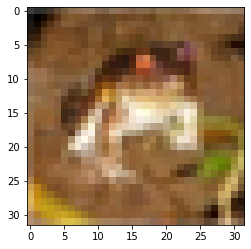

[[-2627.6497 -1865.7086 -2343.4956 -1973.1934 -1931.3289 -2773.7368
  -1429.9877 -2399.2869 -2631.6418 -2146.8538]] tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


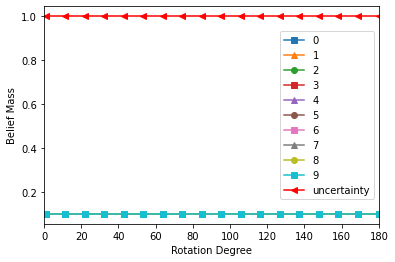

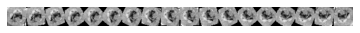

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [45]:
test_img = x_train[0]
label = y_train[0]
print("label", np.argmax(label))
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
pred = model.predict(tf.reshape(test_img,(1,32,32)))
print(pred, tf.nn.softplus(pred))
rotateImg(model,test_img, (32,32))

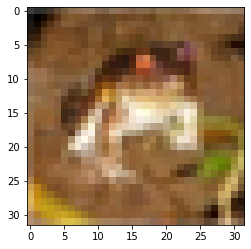

[[-289.1947  -171.10464 -129.00856 -197.74854 -262.961   -187.55244
  -126.85837 -278.85153 -166.8904  -272.0781 ]] tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


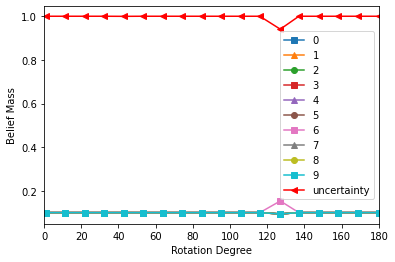

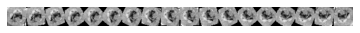

[1.0,
 1.0,
 1.0,
 1.0,
 0.99957496,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9406858,
 1.0,
 0.99993074,
 1.0,
 1.0,
 1.0]

In [33]:
test_img = x_train[0]
plt.imshow(test_img)
plt.show()

test_img = tf.image.rgb_to_grayscale(test_img, name=None)
pred = model.predict(tf.reshape(test_img,(1,32,32)))
print(pred, tf.nn.softplus(pred))
rotateImg(model,test_img, (32,32))

In [16]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(32,32,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    annealing = tf.minimum(1,tf.cast(i/100,tf.float32))
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7551 - accuracy: 0.3886
annealing_coef: tf.Tensor(0.01, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7567 - accuracy: 0.4931
annealing_coef: tf.Tensor(0.02, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7529 - accuracy: 0.5133
annealing_coef: tf.Tensor(0.03, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7498 - accuracy: 0.5317
annealing_coef: tf.Tensor(0.04, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7540 - accuracy: 0.5392
annealing_coef: tf.Tensor(0.05, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step - loss: 0.7587 - accuracy: 0.5441
annealing_coef: tf.Tensor(0.06, shape=(), dtype=float32)
1406/1406 [==============================] - 7s 4ms/step

In [13]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(4):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=evidence_crossentropy(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 121s 66ms/step - loss: 0.5473 - accuracy: 0.6222
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 128s 71ms/step - loss: 0.7875 - accuracy: 0.4662
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 129s 71ms/step - loss: 0.7242 - accuracy: 0.4951
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 129s 71ms/step - loss: 0.8150 - accuracy: 0.3646


In [16]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(4):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=evidence_crossentropy(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 10s 5ms/step - loss: 0.1313 - accuracy: 0.9218
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 5ms/step - loss: 0.1344 - accuracy: 0.9647
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 9s 4ms/step - loss: 0.1482 - accuracy: 0.9674
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 11s 6ms/step - loss: 0.1608 - accuracy: 0.9695


1


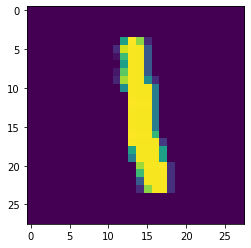

In [123]:
import matplotlib.pyplot as plt
digit_one = x_train[6]

print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [135]:
def rotate_img_crossevidence(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
    #     print(_pred)
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1


        # evidence = tf.nn.relu(_pred)
        # alpha = evidence + 1

        u = tf.reduce_sum(evidence, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        print("prob", evidence)
        print("u", u.numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += evidence.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(evidence[0])
        print(u.numpy())
        pred.append(pred)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    for j in range(len(labels)):
        print(labels[j])
        print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.18844621]] prob 0.18844621
[[0.18844621]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[5.2325004e-07]] prob 5.2325004e-07
[[5.2325004e-07]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[6.233804e-05]] prob 6.233804e-05
[[6.233804e-05]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.1377818e-07]] prob 1.1377818e-07
[[1.13

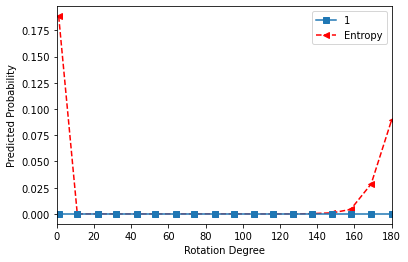

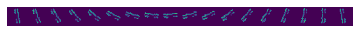

[0.18844621, 5.2325004e-07, 6.233804e-05, 1.1377818e-07, 9.085725e-11, 1.1687073e-08, 5.7493697e-05, 2.9753628e-05, 9.05475e-05, 7.244954e-05, 7.7653635e-09, 1.6452828e-10, 3.8197495e-06, 0.00027558542, 0.0010198655, 0.004291958, 0.028569005, 0.08956691]


In [136]:
rotate_img_crossevidence(model)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.98150396]] prob 1.0
[[0.98150396]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[0.9999937]] prob 0.9999999
[[0.9999937]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[2.2831786e-16 5.1840771e-11 3.6141695e

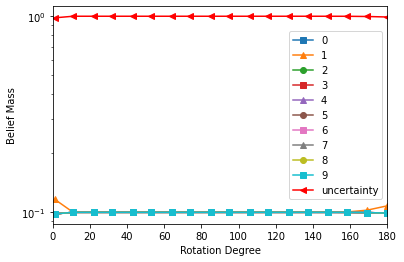

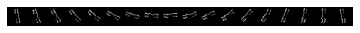

[0.98150396, 1.0, 0.9999937, 1.0, 1.0, 1.0, 0.9999943, 0.999997, 0.99999094, 0.9999927, 1.0, 1.0, 0.99999964, 0.99997246, 0.9998981, 0.999571, 0.9971512, 0.9911228]


In [124]:
import tensorflow_addons as tfa
linspace = np.linspace(1,180,num=18)
digit_one = x_train[6]
import matplotlib.pyplot as plt
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
K = 10
# print(linspace)
pred = []
uncert = []
label = []
answer = []
ldeg = []
lp = []
lu=[]
scores = np.zeros((1,K))
threshold = 0.001
Results = pd.DataFrame()
rimgs = []
K=10
from PIL import Image

for i in linspace:
    i = int(i)
    radians = i* np.pi/180
    # print(radians)
    rotate = tfa.image.rotate(digit_one, tf.constant(radians))
    rimg = rotate
    rimgs.append(rimg.numpy().reshape(28,28))
#     rimgs.append(rotate)
    _pred=model.predict(tf.reshape(rotate,(1,28,28)))
#     print(_pred)
    # evidence = tf.nn.relu(_pred)
    evidence = tf.nn.softplus(_pred)
    # alpha = evidence + 1
    
    
    # evidence = tf.nn.relu(_pred)
    alpha = evidence + 1

    u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

    prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
    print("prob", evidence)
    print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
    # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
    # prob = evidence/tf.reduce_sum(evidence, 1) 
#     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
    scores += prob.numpy().astype("float") >= threshold
#     print("scores",scores)
    lp.append(prob[0])
    print(u.numpy())
    pred.append(prob)
    uncert.append(u.numpy().mean())
    label.append(1)
    answer.append(np.argmax(_pred))
    ldeg.append(i)
labels = np.arange(10)[scores[0].astype(bool)]
# print("labels",labels)
lp = np.array(lp)[:,labels]
# c = ['black','blue','red','brown','purple','cyan']
marker = ['s','^','o']*4
labels = labels.tolist()
# print("lp",lp)

print(labels)
for j in range(len(labels)):
    # print(lp[:,j], answer[j])
    
    
    plt.plot(ldeg,lp[:,j],marker=marker[j])
    


labels += ['uncertainty']
plt.plot(ldeg,uncert,marker='<',c='red')

plt.legend(labels)
 
plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Belief Mass')
plt.yscale("log")
plt.show()

img = Image.new('L', (28*len(rimgs), 28))
x_offset =0
for im in rimgs:
#     print(im)
    _im = Image.fromarray(np.uint8((im)*255))
    img.paste(_im,(x_offset,0))
    x_offset += _im.size[0]
    
plt.figure(figsize=[6.2,100])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
#     print(pred, np.argmax(pred))
#     _ = plt.imshow(rotate)
#     plt.show()
print(uncert)

In [102]:
def rotate_img_entropy():
    def calcEntropy_Tensors2(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies

    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        prob = _pred
        # evidence = tf.nn.relu(_pred)
        # evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        
        u = calcEntropy_Tensors2(prob)
        print("prob", _pred)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += _pred.astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    print(labels)
    for j in range(len(labels)):
        print(lp[:,j], answer[j])


        plt.plot(ldeg,lp[:,j],marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass / Entropy Score')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [161]:
def rotate_img_crossentropy(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        prob = np.amax(evidence)
        # u = prob
        u = tf.reduce_sum(evidence, axis=1, keepdims=True).numpy() #uncertainty
        # u = np.reduce_sum(evidence)
        print("prob", evidence)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.astype("float") 
    #     print("scores",scores)
    
    
    
        lp.append(evidence[0])
        pred.append(prob)
        uncert.append(u.mean())
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    plt.yscale('log')
    
    for j in range(len(labels)):
        print(labels[j])
        # print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Certanity']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[1.0964890e-08 1.6847100e+00 1.8928564e-06 1.7925127e-07 1.0670565e-05
  1.3333648e-07 1.7490745e-06 7.6637001e-08 4.9270166e-05 8.1341007e-08]], shape=(1, 10), dtype=float32)
u 1.684774 prob 1.684774
prob tf.Tensor(
[[1.7824584e-11 1.1883412e-01 1.5200213e-05 1.5144473e-06 4.2996984e-09
  1.9316868e-08 1.9449025e-09 4.2931267e-09 2.6531627e-05 3.0361946e-08]], shape=(1, 10), dtype=float32)
u 0.118877426 prob 0.118877426
prob tf.Tensor(
[[1.36075247e-13 1.04371775e-02 9.44117801e-06 4.49078152e-09
  3.29475256e-08 6.18469675e-09 1.22163451e-11 2.27892749e-09
  3.26600897e-08 1.74050375e-11]], shape=(1, 10), dtype=float32)
u 0.010446697 prob 0.010446697
prob tf.Tensor(
[[4.16907963e-13 2.50979941e-02 1.35669552e-06 1.01298845e-08
  2.57853173e-07 1.42367573e-09 3.64997637e-13 1.56718940e-07
  1.30392586e-10 1.41429099e-11]], shape=(1, 10), dtype=float32)
u 0.025099777 prob 0.025099777
prob tf.Tensor(
[[2.4253839e-12 4.2358489e-04 2.6399945e-07 1.8646899e-07 1.4848588e-1

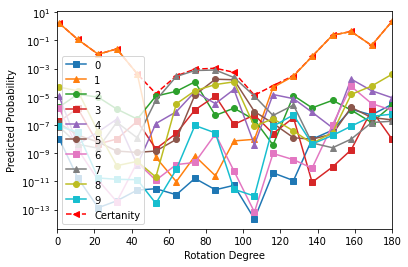

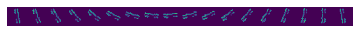

[1.684774, 0.118877426, 0.010446697, 0.025099777, 0.00042404947, 1.709822e-05, 0.00030606764, 0.00091905124, 0.0010624992, 0.00054995023, 1.3065878e-05, 6.1701656e-05, 0.0003175327, 0.0073545645, 0.23709308, 0.43235517, 0.044037566, 2.30327]


In [163]:
rotate_img_crossentropy(model2)